# PyCoSim Example: Model identification
The purpose of this example is to demonstrate how PyCoSim is used for model identification using optimization algorithm.
The content will cover
- loading FMU
- interfacing FMUs to create a system
- running system with different parameter sets in the optimization loop

## Task
Given the system simulation results and a set of known parameters, identify the heat transfer coefficient of the wall
between two control volumes and the same for the surface exposed to environment.


## System description
![System structure](ThermalSystemModelIdentification.png)

The system has two control volumes with a wall in common. It is modelled as shown in the figure. The arrow
indicates a direction of positive energy flow. The heat source will warm up the upper control volume while
heat transfer happens between two control volumes by defined heat transfer coefficient. Two control volumes
will lose heat to environment which has a constant temperature.

### Control volume
Each control volume has four energy ports: heat source, heat transfer input, heat transfer output and
heat loss to environment. Inside the control volume, a first law of thermodynamics is applied to calculate
the rate of change in the internal energy in the control volume and the temperature is calculated.

$$E_{CV} = \int \dot{E}_\text{source} + \dot{E}_\text{transfer input} - \dot{E}_{\text{transfer output}} - \dot{Q}_\text{heat loss} dt $$

$$T_{CV} = E_{CV} / m_{CV} / C_{CV} $$

where $\dot{E}$ is a rate of heat transfer or heat input, $\dot{Q}$ is a rate of heat loss, and
$T, m, C$
is temperature, mass and heat capacity of the control volume.

### Wall Heat Transfer and Heat Loss to Environment
The wall heat transfer works as a energy flow restriction between two control volumes. The rate of
heat transfer is determined by the temperature difference between the control volumes ($\Delta T$),
area ($a$) and its heat transfer coefficient ($h$).

$$\dot{E}_\text{transfer} = h A \Delta T$$

The upper control volume has a heat source connected which provides thermal
power by prescribed values or function. Its heat transfer input port is adiabatic (no heat transfer)
and its heat transfer output port is connected to wall heat transfer element. Its heat loss port is
connected to HeatLossCV1 component which prescribes the heat loss to environment.
The lower has no heat source and its heat transfer output port is adiabatic. These ports are
connected to zero heat flow element. Its heat transfer input is connected to wall heat transfer
element and its heat loss port to HeatLossCV2 component. Each HeatLoss component is connected to
the ambient temperature element which provides a constant temperature.

## Simulation scenario
1. A heat source provides thermal power 1000W to the upper control volume between 5 to 10 seconds.
Initial temperature
of two control volumes are 300K and the ambient temperature is 330K.
2. A heat source provides thermal power 2000W to the upper control volume between 5 to 10 seconds.
Initial temperature of two control volumes are 300K and the ambient temperature is 330K.

The temperature change for 100 seconds for both cases are shown below.

<AxesSubplot:xlabel='time{s}'>

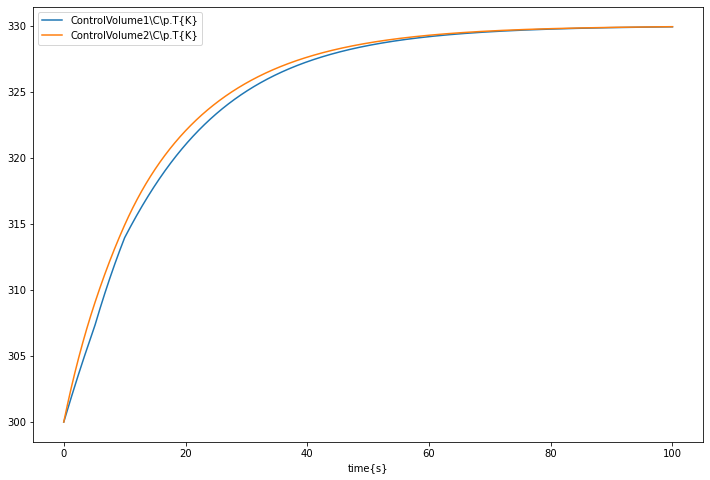

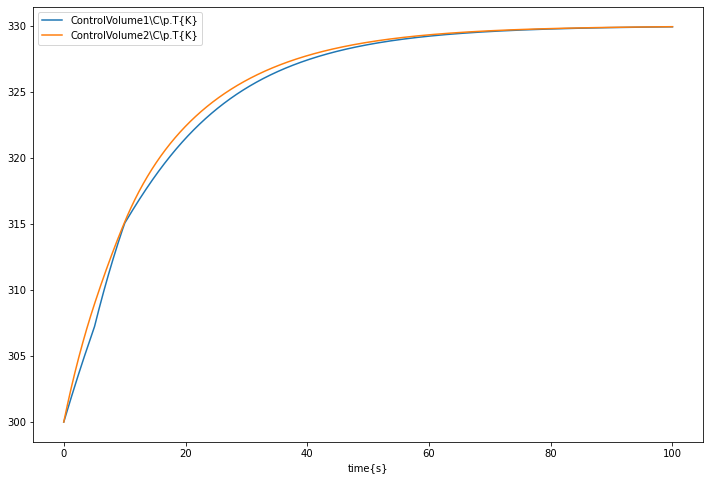

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyOSPParser.logging_configuration import OspLoggingConfiguration
from pyOSPParser.system_configuration import OspVariableEndpoint
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

from pycosim.osp_command_line_interface import LoggingLevel, SimulationError
from pycosim.simulation import FMU, SimulationConfiguration

PLOT_SIZE = (12, 8)

PATH_TO_DIR = os.getcwd()
PATH_TO_DATA1 = os.path.join(PATH_TO_DIR, 'experiment1_1000W_5_10.csv')
PATH_TO_DATA2 = os.path.join(PATH_TO_DIR, 'experiment2_2000W_5_10.csv')

df_scenario1 = pd.read_csv(PATH_TO_DATA1)
df_scenario2 = pd.read_csv(PATH_TO_DATA2)

df_scenario1.plot(x='time{s}', figsize=PLOT_SIZE)
df_scenario2.plot(x='time{s}', figsize=PLOT_SIZE)

## Create FMU instances
We need to create FMU instances to will be used to create components in the system. Note that we only create one
control volume FMU since an identical model will be used for both control volumes.

In [2]:
PATH_TO_FMU_CV = os.path.join(PATH_TO_DIR, '..', 'fmus', 'thermal', 'ControlVolume.fmu')
PATH_TO_FMU_PULSE =os.path.join(PATH_TO_DIR, '..', 'fmus', 'signals', 'Pulse.fmu')
PATH_TO_FMU_WALL = os.path.join(PATH_TO_DIR, '..', 'fmus', 'thermal', 'WallHeatTransfer.fmu')
PATH_TO_CONSTANT = os.path.join(PATH_TO_DIR, '..', 'fmus', 'signals', 'Constant.fmu')

# Create fmu instances for the models
control_volume_fmu = FMU(PATH_TO_FMU_CV)  # For control volumes
wall_heat_transfer_fmu = FMU(PATH_TO_FMU_WALL)  # For heat transfer between the control volumes
pulse_signal_fmu = FMU(PATH_TO_FMU_PULSE)  # For heat source
constant_signal_fmu = FMU(PATH_TO_CONSTANT)  # For ambient temperature

fmus = [
    control_volume_fmu,
    wall_heat_transfer_fmu,
    pulse_signal_fmu,
    constant_signal_fmu
]

# Examine each FMU
for fmu in fmus:
    print('------------------------------')
    print(f'{fmu.name}')
    print(f'  input: {fmu.get_input_names()}')
    print(f'  output: {fmu.get_output_names()}')
    print(f'  parameters: {fmu.get_parameter_names()}')
    print(f'  other variables: {fmu.get_other_variable_names()}')

------------------------------
ControlVolume
  input: ['p_in.dQ', 'p_transfer_in.dQ', 'p_loss.dQ', 'p_transfer_out.dQ']
  output: ['p_in.T', 'p_transfer_in.T', 'p_loss.T', 'p_transfer_out.T']
  parameters: ['m', 'c', 'T0', 'C.u0']
  other variables: ['C.p.T', 'ZeroJunction.effort', 'ZeroJunction.p1.T', 'ZeroJunction.p2.T', 'ZeroJunction.p3.T', 'ZeroJunction.p4.T', 'ZeroJunction.p5.T', 'ZeroJunction.p1.dQ', 'ZeroJunction.p2.dQ', 'ZeroJunction.p3.dQ', 'ZeroJunction.p4.dQ', 'ZeroJunction.p5.dQ', 'C.p.dQ', 'C.state']
------------------------------
WallHeatTransfer
  input: ['p_out.T', 'p_in.T']
  output: ['p_out.dQ', 'p_in.dQ']
  parameters: ['h_wall', 'A_wall']
  other variables: ['OneJunction.flow', 'OneJunction.p1.T', 'OneJunction.p2.T', 'OneJunction.p3.T', 'OneJunction.p1.dQ', 'OneJunction.p2.dQ', 'OneJunction.p3.dQ', 'R.p.e', 'R.p.f']
------------------------------
Pulse
  input: []
  output: ['output']
  parameters: ['start_time', 'stop_time', 'amplitude']
  other variables: []
-----

## Creating system - bottom-up building
We create a system from empty structure by adding components and connections.

In [3]:
# Create an simulation configuration instance with empty system configuration
sim_config = SimulationConfiguration()
# Now we will add components
sim_config.add_component(name='ControlVolume1', fmu=control_volume_fmu)
sim_config.add_component(name='ControlVolume2', fmu=control_volume_fmu)
sim_config.add_component(name='WallHeatTransfer', fmu=wall_heat_transfer_fmu)
sim_config.add_component(name='HeatLossCV1', fmu=wall_heat_transfer_fmu)
sim_config.add_component(name='HeatLossCV2', fmu=wall_heat_transfer_fmu)
sim_config.add_component(name='HeatSource', fmu=pulse_signal_fmu)
sim_config.add_component(name='AmbientCondition', fmu=constant_signal_fmu)

Component(name='AmbientCondition', fmu=<pycosim.simulation.FMU object at 0x0000027D9B5CD3C8>)

In [4]:
# Now we add connections
sim_config.add_connection(  # Heat source dQ to control volume 1
    source=OspVariableEndpoint(simulator='HeatSource', name='output'),
    target=OspVariableEndpoint(simulator='ControlVolume1', name='p_in.dQ'),
    group=False
)
sim_config.add_connection(  # Control volume 1 temperature to heat loss from control volume 1
    target=OspVariableEndpoint(simulator='HeatLossCV1', name='p_in.T'),
    source=OspVariableEndpoint(simulator='ControlVolume1', name='p_loss.T'),
    group=False
)
sim_config.add_connection(  # Heat loss from CV 1 heat flow to control volume 1
    source=OspVariableEndpoint(simulator='HeatLossCV1', name='p_in.dQ'),
    target=OspVariableEndpoint(simulator='ControlVolume1', name='p_loss.dQ'),
    group=False
)
sim_config.add_connection(  # Ambient temperature to heat loss from control volume 1
    source=OspVariableEndpoint(simulator='AmbientCondition', name='output'),
    target=OspVariableEndpoint(simulator='HeatLossCV1', name='p_out.T'),
    group=False
)
sim_config.add_connection(  # Control volume 1 temperature to wall
    source=OspVariableEndpoint(simulator='ControlVolume1', name='p_transfer_out.T'),
    target=OspVariableEndpoint(simulator='WallHeatTransfer', name='p_in.T'),
    group=False
)
sim_config.add_connection(  # Wall heat transfer dQ to control volume 1
    source=OspVariableEndpoint(simulator='WallHeatTransfer', name='p_in.dQ'),
    target=OspVariableEndpoint(simulator='ControlVolume1', name='p_transfer_out.dQ'),
    group=False
)
sim_config.add_connection(  # Wall heat transfer dQ to control volume 2
    source=OspVariableEndpoint(simulator='WallHeatTransfer', name='p_out.dQ'),
    target=OspVariableEndpoint(simulator='ControlVolume2', name='p_transfer_in.dQ'),
    group=False
)
sim_config.add_connection(  # Control volume 2 temperature to wall
    source=OspVariableEndpoint(simulator='ControlVolume2', name='p_transfer_in.T'),
    target=OspVariableEndpoint(simulator='WallHeatTransfer', name='p_out.T'),
    group=False
)
sim_config.add_connection(  # Ambient temperature to control volume 2
    source=OspVariableEndpoint(simulator='ControlVolume2', name='p_loss.T'),
    target=OspVariableEndpoint(simulator='HeatLossCV2', name='p_in.T'),
    group=False
)
sim_config.add_connection(  # Ambient temperature to control volume 2
    source=OspVariableEndpoint(simulator='HeatLossCV2', name='p_in.dQ'),
    target=OspVariableEndpoint(simulator='ControlVolume2', name='p_loss.dQ'),
    group=False
)
sim_config.add_connection(  # Ambient temperature to control volume 2
    source=OspVariableEndpoint(simulator='AmbientCondition', name='output'),
    target=OspVariableEndpoint(simulator='HeatLossCV2', name='p_out.T'),
    group=False
)

## Run a test simulation with a logging configuration
Now we can run the simulation. But first, we need to configure output logging
to only get relevant outputs in the output file and set initial values for the heat source.

In [5]:
# Logging configuration
sim_config.logging_config = OspLoggingConfiguration()
sim_config.add_logging_variable(
    component_name='ControlVolume1',
    variable_name='p_transfer_out.T'
)
sim_config.add_logging_variable(
    component_name='ControlVolume2',
    variable_name='p_transfer_in.T'
)

# Initial values or parameter setting
sim_config.add_update_initial_value(  # Specific heat capacity of CV1
    component_name='ControlVolume1',
    variable='c',
    value=1003.5,
    type_value=float
)
sim_config.add_update_initial_value(  # Mass of CV1
    component_name='ControlVolume1',
    variable='m',
    value=3.5,
    type_value=float
)
sim_config.add_update_initial_value(  # Initial temperature of CV1
    component_name='ControlVolume1',
    variable='T0',
    value=300,
    type_value=float
)
sim_config.add_update_initial_value(  # Specific heat capacity of CV1
    component_name='ControlVolume2',
    variable='c',
    value=1003.5,
    type_value=float
)
sim_config.add_update_initial_value(  # Mass of CV1
    component_name='ControlVolume2',
    variable='m',
    value=2.4,
    type_value=float
)
sim_config.add_update_initial_value(  # Initial temperature of CV1
    component_name='ControlVolume2',
    variable='T0',
    value=300,
    type_value=float
)
sim_config.add_update_initial_value(  # Heat transfer coefficient for CV1 toward surrounding
    component_name='HeatLossCV1',
    variable='h_wall',
    value=60,
    type_value=float
)
sim_config.add_update_initial_value(  # Area of CV1 toward surrounding
    component_name='HeatLossCV1',
    variable='A_wall',
    value=3,
    type_value=float
)
sim_config.add_update_initial_value(  # Heat transfer coefficient for CV2 toward surrounding
    component_name='HeatLossCV2',
    variable='h_wall',
    value=60,
    type_value=float
)
sim_config.add_update_initial_value(  # Area of CV2 toward surrounding
    component_name='HeatLossCV2',
    variable='A_wall',
    value=3,
    type_value=float
)
sim_config.add_update_initial_value(  # Area between CV1 and CV2
    component_name='WallHeatTransfer',
    variable='A_wall',
    value=1,
    type_value=float
)
sim_config.add_update_initial_value(  # heat transfer coefficient between CV1 and CV2
    component_name='WallHeatTransfer',
    variable='h_wall',
    value=240,
    type_value=float
)
sim_config.add_update_initial_value(  # Start time for heat flow into CV1
    component_name='HeatSource',
    variable='start_time',
    value=5,
    type_value=float
)
sim_config.add_update_initial_value(  # Stop time for heat flow into CV1
    component_name='HeatSource',
    variable='stop_time',
    value=10,
    type_value=float
)
sim_config.add_update_initial_value(  # Heat flow during the pulse
    component_name='HeatSource',
    variable='amplitude',
    value=1000,
    type_value=float
)
sim_config.add_update_initial_value(  # Ambient temperature
    component_name='AmbientCondition',
    variable='C',
    value=330,
    type_value=float
)

InitialValues(component='AmbientCondition', variable='C', value=330)

In [6]:
sim_output = sim_config.run_simulation(duration=100, logging_level=LoggingLevel.info)
if len(sim_output.error) > 0:
    raise SimulationError(f'There was an error running the simulation\n{sim_output.error}')
df_result = sim_output.result

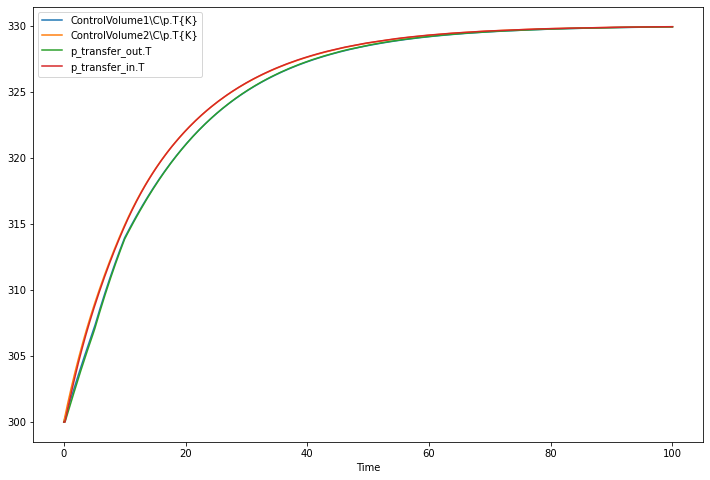

In [7]:
fig, ax = plt.subplots()
df_scenario1.plot(x='time{s}', ax=ax, figsize=PLOT_SIZE)  # Referece
df_result['ControlVolume1'].drop(['StepCount'], axis=1).plot(x='Time', ax=ax, figsize=PLOT_SIZE)
df_result['ControlVolume2'].drop(['StepCount'], axis=1).plot(x='Time', ax=ax, figsize=PLOT_SIZE)
plt.show()

We will change the heat input parameter and compare the change

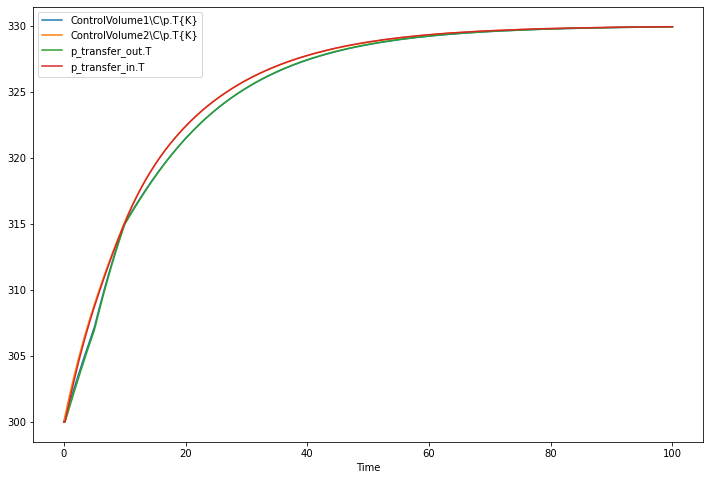

In [8]:
sim_config.add_update_initial_value(  # Heat flow into CV1
    component_name='HeatSource',
    variable='amplitude',
    value=2000,
    type_value=float
)

# Run simulation, retrieve the result and plot it
sim_output = sim_config.run_simulation(duration=100, logging_level=LoggingLevel.info)
if len(sim_output.error) > 0:
    raise SimulationError(f'There was an error running the simulation\n{sim_output.error}')
df_result = sim_output.result
fig, ax = plt.subplots()
df_scenario2.plot(x='time{s}', ax=ax, figsize=PLOT_SIZE)  # Reference plot
df_result['ControlVolume1'].drop(['StepCount'], axis=1).plot(x='Time', ax=ax, figsize=PLOT_SIZE)
df_result['ControlVolume2'].drop(['StepCount'], axis=1).plot(x='Time', ax=ax, figsize=PLOT_SIZE)
plt.show()

## Model identification
We will assume that we don't know the heat capacity of the control volume 2. Given the experimental
result, we will try to find this parameter. This problem can be solved using an optimization
algorithm. The cost function for the optimization problem is defined as:

$$\sum_{i=1}^{n}{\left(T_{i, \text{cv1 ref}} - T_{i, \text{cv1 sim}}\right)^2 + \left(T_{i, \text{cv2 ref}} - T_{i, \text{cv2 sim}}\right)^2}$$


c: 3819.660112501051, square_error: 638025.4350576185
c: 6180.339887498948, square_error: 1472386.7224541423
c: 2360.679774997897, square_error: 197847.47273297422
c: 1458.9803375031547, square_error: 28219.679628373277
c: 901.6994374947426, square_error: 1473.4455881795575
c: 930.4841079029002, square_error: 763.384538096148
c: 1005.8011411879074, square_error: 124.35179396054765
c: 995.4315519069746, square_error: 110.49628077467703
c: 996.1981101952803, square_error: 110.37867405952788
c: 996.3093678354757, square_error: 110.40631733361008
c: 995.982387119397, square_error: 110.36788080658665
c: 995.7719867904519, square_error: 110.43781850227768
c: 996.0490253360413, square_error: 110.40046957478833
c: 995.9020213449842, square_error: 110.4202175891387
c: 995.9516901251035, square_error: 110.3842285692211
c: 996.0078406532054, square_error: 110.38970007241414
c: 995.9706619109294, square_error: 110.38214040828915
c: 995.9921095041781, square_error: 110.36716299488998
c: 995.9981182

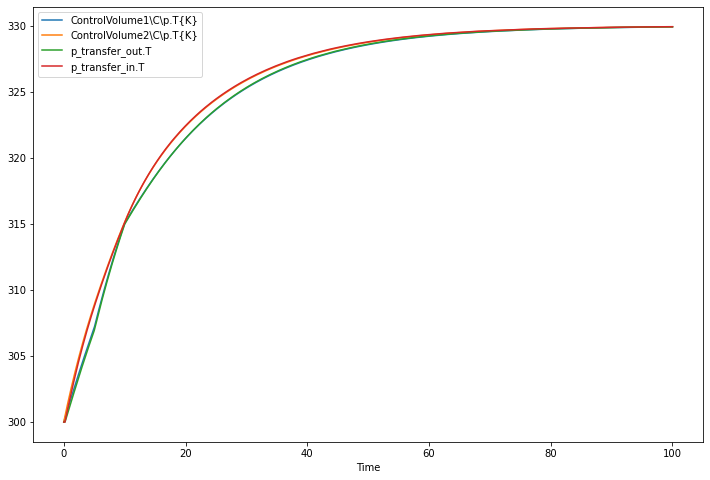

In [9]:
# Cost function
def cost(c_cv2: float) -> float:
    sim_config.add_update_initial_value(  # Specific heat capacity of CV1
        component_name='ControlVolume2',
        variable='c',
        value=c_cv2,
        type_value=float
    )
    output = sim_config.run_simulation(duration=100)
    if len(output.error) > 0:
        raise SimulationError(f'There was an error running the simulation\n{sim_output.error}')
    time_ref = df_scenario2['time{s}'].values
    temp_cv1_ref = df_scenario2['ControlVolume1\C\p.T{K}'].values
    time_sim = output.result['ControlVolume1']['Time'].values
    temp_cv1_sim = output.result['ControlVolume1']['p_transfer_out.T'].values
    interp = interp1d(x=time_sim, y=temp_cv1_sim, kind='cubic', fill_value="extrapolate")
    temp_cv1_sim_int = interp(time_ref)
    temp_cv2_ref = df_scenario2['ControlVolume2\C\p.T{K}'].values
    time_sim = output.result['ControlVolume2']['Time'].values
    temp_cv2_sim = output.result['ControlVolume2']['p_transfer_in.T'].values
    interp = interp1d(x=time_sim, y=temp_cv2_sim, kind='cubic', fill_value='extrapolate')
    temp_cv2_sim_int = interp(time_ref)
    square_error =  np.sum(
        np.square(temp_cv1_ref - temp_cv1_sim_int) +
        np.square(temp_cv2_ref - temp_cv2_sim_int)
    )
    print(f'c: {c_cv2}, square_error: {square_error}')
    return square_error

# Run optimization
res = minimize_scalar(cost, bounds=(0, 10000), method='bounded')
print(f'Heat capacity of the control volume 2 is {res.x}.')
sim_config.add_update_initial_value(
    component_name='ControlVolume2',
    variable='c',
    value=res.x,
    type_value=float
)

# Run simulation with the parameter found and show the result
sim_output = sim_config.run_simulation(duration=100)
df_result = sim_output.result
fig, ax = plt.subplots()
df_scenario2.plot(x='time{s}', ax=ax, figsize=PLOT_SIZE)  # Reference plot
df_result['ControlVolume1'].drop(['StepCount'], axis=1).plot(x='Time', ax=ax, figsize=PLOT_SIZE)
df_result['ControlVolume2'].drop(['StepCount'], axis=1).plot(x='Time', ax=ax, figsize=PLOT_SIZE)
plt.show()

## Conclusion
It is interesting that the heat capacity of the control volume was found to be 996.0 which is
0.75% off the correct value of 1003.5. When we tried with the correc value, square error
was 118 which is greater than the one with optimal solution. This must be due to the error
introduced by co-simulation which is quite small in this case.

